In [11]:
import os

os.chdir("..")
# print(os.getcwd()) 

import warnings
warnings.simplefilter("ignore", category=UserWarning)

In [12]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

from Models import Generators, Discriminators, LossFunctions
import Models.utils as utils

In [13]:
df = pd.read_csv("Data/Maternal Health Risk Data Set.csv")
df = df.dropna()
numeric_cols = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
df = df[numeric_cols]

scaler = MinMaxScaler()
data = scaler.fit_transform(df)  # Normalizar datos entre 0 y 1
data_dim = data.shape[1]

FileNotFoundError: [Errno 2] No such file or directory: 'Data/Maternal Health Risk Data Set.csv'

In [20]:
class EncoderDecoderCNN1D(nn.Module):
    def __init__(self, input_dim, num_layers=3, initial_filter=256, latent_dim=16, kernel_size=3):
        super(EncoderDecoderCNN1D, self).__init__()
        
        if latent_dim is None:
            latent_dim = initial_filter // (2 ** (num_layers - 1))
        
        # ###############
        # ### Encoder ###
        # ###############
        encoder_list = []
        for i in range(num_layers):
            if i == 0:
                encoder_list.extend(self.custom_conv_block(input_dim, initial_filter, kernel_size=kernel_size))
                filter = initial_filter
            else:
                encoder_list.extend(self.custom_conv_block(filter, filter // 2, kernel_size=kernel_size))
                filter //= 2
        
        encoder_list.extend(self.custom_conv_block(filter, latent_dim, kernel_size=kernel_size))
        
        self.encoder = nn.Sequential(*encoder_list)
        
        # ###############
        # ### Decoder ###
        # ###############
        decoder_filter = latent_dim
        decoder_list = []
        for _ in range(num_layers):
            decoder_list.extend(self.custom_deconv_block(decoder_filter, 2 * decoder_filter, kernel_size=kernel_size))
            decoder_filter *= 2

        
        decoder_list.extend(self.custom_conv_block(decoder_filter, input_dim, kernel_size=kernel_size))
        decoder_list.append(nn.Sigmoid())
        
        self.decoder = nn.Sequential(*decoder_list)

    @staticmethod
    def custom_conv_block(input_dim, output_dim, kernel_size=5, dropout_rate=0.1):
        return [
            nn.Conv1d(input_dim, output_dim, kernel_size=kernel_size, padding=1, stride=1), 
            nn.BatchNorm1d(output_dim), 
            nn.ReLU(), 
            nn.Dropout(dropout_rate)
        ]
    
    @staticmethod
    def custom_deconv_block(input_dim, output_dim, kernel_size=5, dropout_rate=0.1):
        return [
            nn.ConvTranspose1d(input_dim, output_dim, kernel_size=kernel_size, stride=2, padding=1, output_padding=0), 
            nn.BatchNorm1d(output_dim), 
            nn.ReLU(), 
            nn.Dropout(dropout_rate)
        ]
    
    def forward(self, z):
        latent_output = self.encoder(z)
        output = self.decoder(latent_output)
        return output


generator = EncoderDecoderCNN1D(input_dim=data_dim)
optimizer_g = optim.Adam(generator.parameters(), lr=1 * 10 ** -4)

In [21]:
discriminator = Discriminators.Discriminator(input_dim=data_dim)
optimizer_d = optim.Adam(discriminator.parameters(), lr=1 * 10 ** -4)

# Loss function
criterion = nn.BCELoss()

In [22]:
t0 = time.time()

num_epochs = 8000
batch_size = 500

all_real_data_torch = torch.tensor(data, dtype=torch.float32)

save_nn_data_list = []
for epoch in range(num_epochs):
    
    idx = np.random.randint(0, data.shape[0], batch_size)
    real_data_array = data[idx]
    real_data = torch.tensor(data[idx], dtype=torch.float32)
    
    # Generar datos falsos
    z = torch.randn(batch_size, data_dim)
    z_minmax = (z - z.min()) / (z.max() - z.min())
    z_reshape = z_minmax.reshape(batch_size, data_dim, 1)
    fake_data_reshape = generator(z_reshape)
    fake_data = fake_data_reshape.reshape(batch_size, data_dim)
    
    if torch.any(torch.isnan(fake_data)) or torch.any(torch.isinf(fake_data)):
        print("Fake data contains NaNs or Infs!")
        break

    if torch.any(torch.isnan(real_data)) or torch.any(torch.isinf(real_data)):
        print("Real data contains NaNs or Infs!")
        break
    
    # Entrenar Discriminador
    optimizer_d.zero_grad()
    real_loss = criterion(discriminator(real_data), torch.ones(batch_size, 1))
    fake_loss = criterion(discriminator(fake_data.detach()), torch.zeros(batch_size, 1))
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_d.step()

    # Entrenar Generador
    optimizer_g.zero_grad()
    g_loss = LossFunctions.custom_loss(fake_data, real_data, method="integral-iqr-covmat")
    g_loss.backward()
    # g_loss.backward()
    optimizer_g.step()

    if epoch % 100 == 0:
        save_nn_data_list.append({
            "epoch": epoch,
            "discriminator_loss": d_loss.item(),
            "generator_loss": g_loss.item()
        })

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

        if utils.stop_training_func(save_nn_data_list, epoch_dist=1000):
                break

print(f"Epoch {epoch + 1}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

df_nn = pd.DataFrame(save_nn_data_list)

training_time = time.time() - t0

print("Training time", np.round((training_time)/60, 4), "min")

Epoch 0, D Loss: 1.6007606983184814, G Loss: 6.766119956970215
Epoch 500, D Loss: 1.4754608869552612, G Loss: 6.18573522567749
Epoch 1000, D Loss: 1.3924020528793335, G Loss: 6.1438398361206055
Epoch 1500, D Loss: 1.3578343391418457, G Loss: 5.6677961349487305
Epoch 2000, D Loss: 1.3207396268844604, G Loss: 5.983256816864014
Epoch 2500, D Loss: 1.3432343006134033, G Loss: 5.67846155166626
Epoch 3000, D Loss: 1.2506780624389648, G Loss: 6.0893731117248535
Epoch 3500, D Loss: 1.1399211883544922, G Loss: 5.633015155792236
Epoch 4000, D Loss: 1.192063331604004, G Loss: 5.348254680633545
Epoch 4401, D Loss: 1.172614336013794, G Loss: 5.463001251220703
Training time 1.723 min


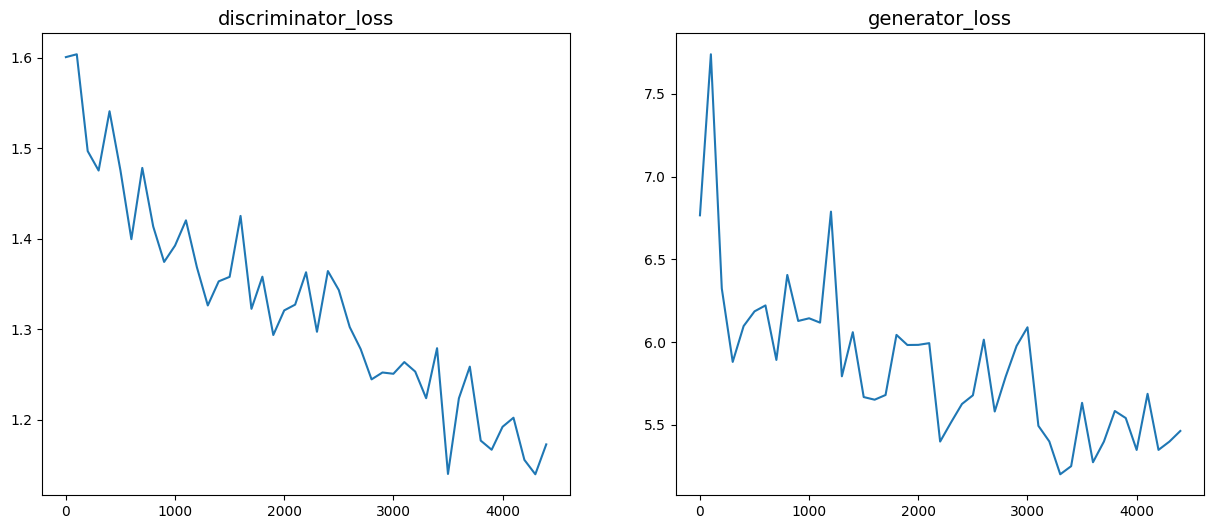

In [23]:
fig = plt.figure(figsize=(15, 6))

fig.add_subplot(1,2,1)
plt.plot(df_nn["epoch"], df_nn["discriminator_loss"])
plt.title("discriminator_loss", fontsize=14)

fig.add_subplot(1,2,2)
plt.plot(df_nn["epoch"], df_nn["generator_loss"])
plt.title("generator_loss", fontsize=14)

plt.show()

In [24]:
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality

numeric_cols = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
sdv_metadata = SingleTableMetadata()
sdv_metadata.detect_from_dataframe(data=df[numeric_cols])
print(sdv_metadata.to_dict())

{'METADATA_SPEC_VERSION': 'SINGLE_TABLE_V1', 'columns': {'Age': {'sdtype': 'numerical'}, 'SystolicBP': {'sdtype': 'numerical'}, 'DiastolicBP': {'sdtype': 'numerical'}, 'BS': {'sdtype': 'numerical'}, 'BodyTemp': {'sdtype': 'numerical'}, 'HeartRate': {'sdtype': 'numerical'}}}


In [25]:
custom_metadata_dict = {
    "Age": "integer",
    "SystolicBP": "integer",
    "DiastolicBP": "integer",
    "BS": "float",
    "BodyTemp": "float",
    "HeartRate": "integer",
}

z = torch.randn(500, data_dim, 1)
z_minmax = (z - z.min()) / (z.max() - z.min())
synthetic_data_reshape = generator(z_minmax).detach().numpy()
synthetic_data = synthetic_data_reshape.reshape(500, data_dim)

# Denormalizar
synthetic_data = scaler.inverse_transform(synthetic_data)

# Guardar en CSV
synthetic_df = pd.DataFrame(synthetic_data, columns=df.columns)
# synthetic_df.to_csv("datos_sinteticos.csv", index=False)


custom_syn_df = synthetic_df.copy()

for col_name, col_type in custom_metadata_dict.items():
    if col_type == "integer":
        custom_syn_df[col_name] = custom_syn_df[col_name].round(0).astype(int)

In [26]:
quality_report = evaluate_quality(
    df[numeric_cols],
    synthetic_df,
    sdv_metadata
)

Creating report: 100%|██████████| 4/4 [00:00<00:00, 33.83it/s]


Overall Quality Score: 63.31%

Properties:
Column Shapes: 37.35%
Column Pair Trends: 89.26%


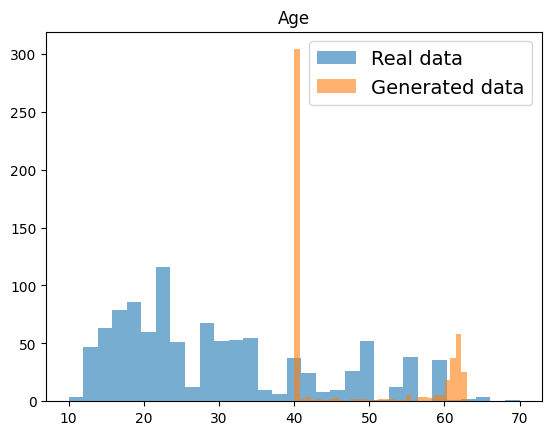

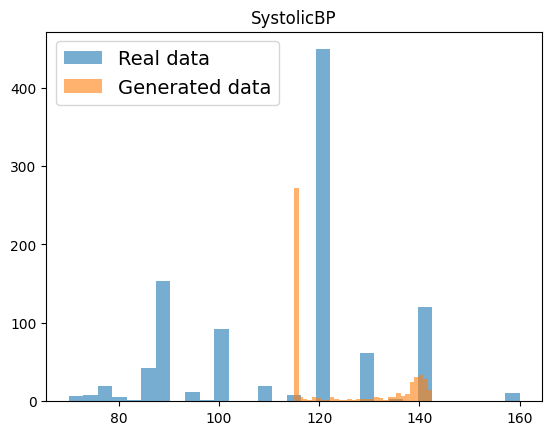

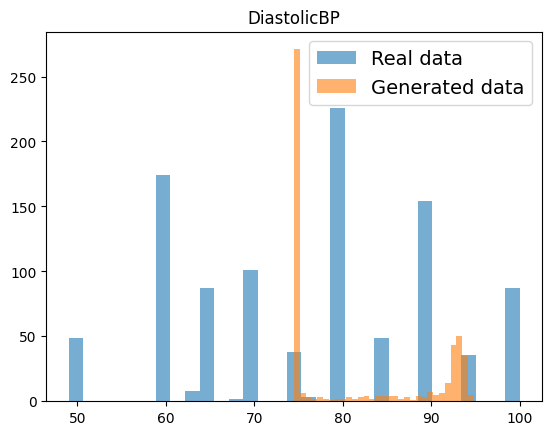

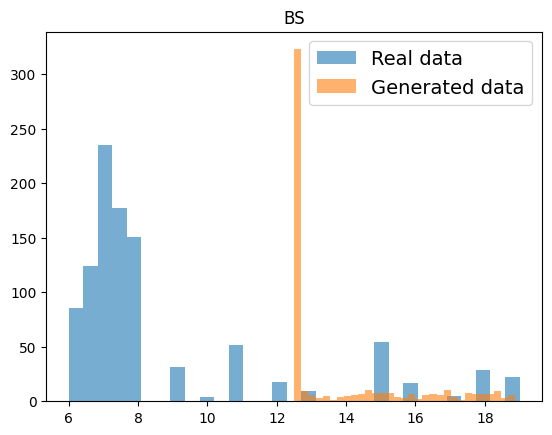

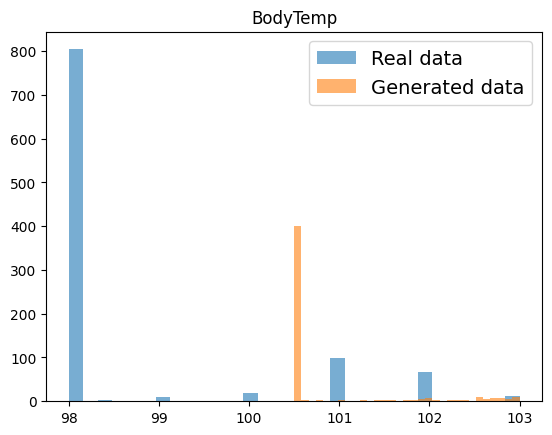

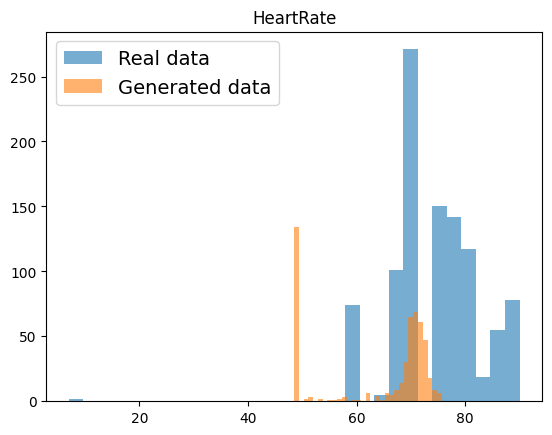

In [27]:
for col in numeric_cols:

    plt.hist(df[col].values, bins=31, alpha=0.6, label="Real data")
    plt.hist(synthetic_df[col].values, bins=31, alpha=0.6, label="Generated data")
    plt.title(col, fontsize=12)
    plt.legend(fontsize=14)
    
    plt.show()